In [8]:
import numpy as np
from xrd_simulator.beam import Beam
# The beam of xrays is represented as a convex polyhedron
# We specify the vertices in a numpy array.
beam_vertices = np.array([
    [-1e6, -500., -500.],
    [-1e6, 500., -500.],
    [-1e6, 500., 500.],
    [-1e6, -500., 500.],
    [1e6, -500., -500.],
    [1e6, 500., -500.],
    [1e6, 500., 500.],
    [1e6, -500., 500.]])

beam = Beam(
    beam_vertices,
    xray_propagation_direction=np.array([1., 0., 0.]),
    wavelength=0.28523,
    polarization_vector=np.array([0., 1., 0.]))

from xrd_simulator.detector import Detector
# The detector plane is defined by it's corner coordinates det_corner_0,det_corner_1,det_corner_2
detector = Detector(pixel_size_z=75.0,
                    pixel_size_y=55.0,
                    det_corner_0=np.array([142938.3, -38400., -38400.]),
                    det_corner_1=np.array([142938.3, 38400., -38400.]),
                    det_corner_2=np.array([142938.3, -38400., 38400.]))

from xrd_simulator.mesh import TetraMesh
# xrd_simulator supports several ways to generate a mesh, here we
# generate meshed solid sphere using a level set.
mesh = TetraMesh.generate_mesh_from_levelset(
    level_set=lambda x: np.linalg.norm(x) - 768.0,
    bounding_radius=769.0,
    max_cell_circumradius=450.)

from xrd_simulator.phase import Phase
quartz = Phase(unit_cell=[4.926, 4.926, 5.4189, 90., 90., 120.],
               sgname='P3221',  # (Quartz)
               path_to_cif_file=None  # phases can be defined from crystalographic information files
               )

In [9]:
from scipy.spatial.transform import Rotation as R
from xrd_simulator.polycrystal import Polycrystal
orientation = R.random(mesh.number_of_elements).as_matrix()
polycrystal = Polycrystal(mesh,
                          orientation,
                          strain=np.zeros((3, 3)),
                          phases=quartz,
                          element_phase_map=None)

In [10]:
polycrystal.save('my_polycrystal', save_mesh_as_xdmf=True)

In [11]:
from xrd_simulator.motion import RigidBodyMotion
motion = RigidBodyMotion(rotation_axis=np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)]),
                         rotation_angle=np.radians(1.0),
                         translation=np.array([123, -153.3, 3.42]))

In [12]:
polycrystal.diffract(beam, detector, motion)
diffraction_pattern = detector.render(frames_to_render=0,
                                        lorentz=False,
                                        polarization=False,
                                        structure_factor=False,
                                        method="project")

Rendering 147 scattering volumes unto the detector      |████████████████████████████████████████| 100.0%


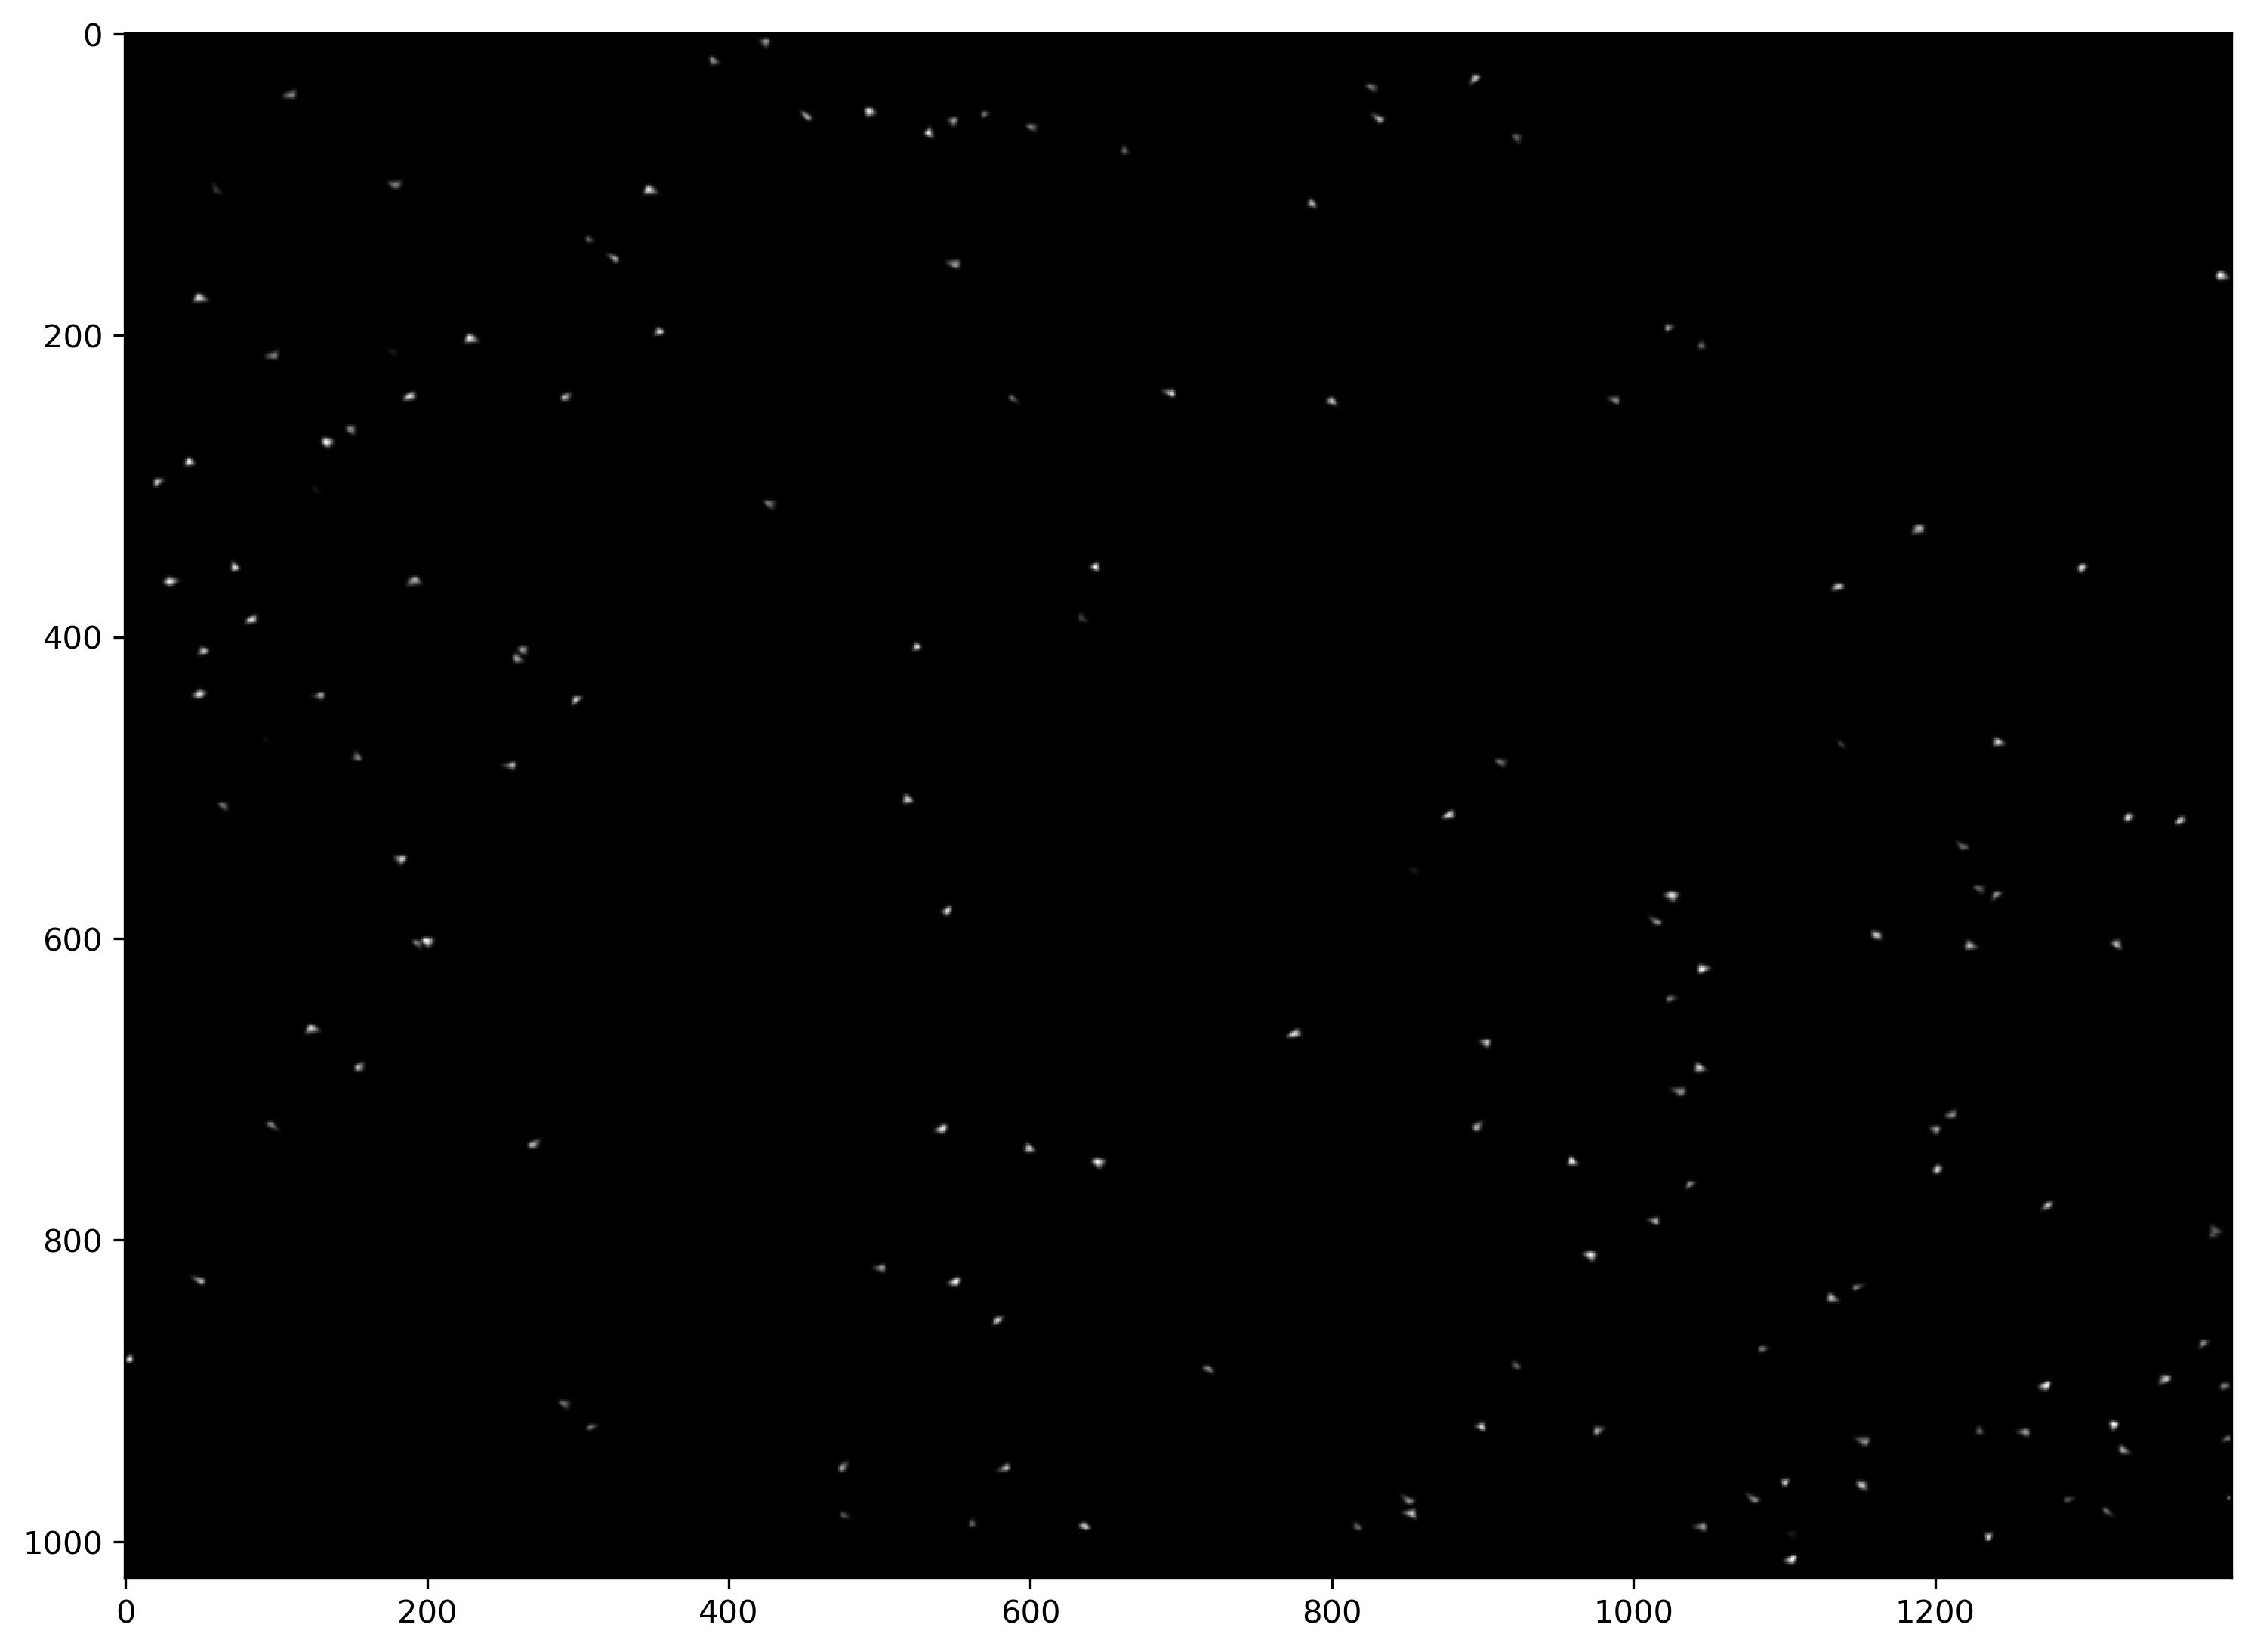

In [13]:
import matplotlib.pyplot as plt
# 设置更大的图片尺寸和更高的DPI
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=300)

# 使用更高质量的显示设置
ax.imshow(diffraction_pattern, cmap='gray', interpolation='nearest')
plt.savefig('diffraction_pattern.png')
plt.show()
